# Efeito da Acessibilidade ao Metrô nos Preços de Imóveis em São Paulo
Notebook demonstrativo – análise geoespacial passo a passo

In [5]:
# Se necessário, instale dependências extras
!pip install geopandas haversine folium contextily pysal pykrige statsmodels

import pandas as pd, geopandas as gpd, numpy as np
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pathlib import Path



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Carregamento e inspeção dos dados

In [6]:
metro_path = Path('datasets/Sao_Paulo/Metro/metrosp_stations_v2.csv')
dados_path = Path('datasets/Sao_Paulo/Real_Estate/dados_wgs.csv')

metro_df = pd.read_csv(metro_path)
print(f'Estações: {metro_df.shape}')
metro_df.head()

dados_df = pd.read_csv(dados_path, sep=';')
print(f'Imóveis: {dados_df.shape}')
dados_df.head()


Estações: (79, 6)
Imóveis: (2499, 26)


,id,valor_total,unit,area_util,quartos,vagas,condominio,suites,banheiros,piscina,...,qtd_dados_bairro,media_idh,media_gini,expectativa_vida,renda_percapita,estacao_prox,linha_prox,dist,lat,lon
0,526,189900,"5934,38",32,2,1,180.0,0,1,0,...,36.0,"0,697181818","0,410909091","72,75181818","559,6681818",SÃO MATEUS,PRATA,"6822,823684","-23,5838787","-46,417548"
1,734,221110,"5142,09",43,2,1,250.0,0,1,0,...,36.0,"0,697181818","0,410909091","72,75181818","559,6681818",CORINTHIANS-ITAQUERA,VERMELHA,"4682,709841","-23,5435347","-46,4254919"
2,738,219990,"5116,05",43,1,1,300.0,0,1,1,...,36.0,"0,697181818","0,410909091","72,75181818","559,6681818",CORINTHIANS-ITAQUERA,VERMELHA,"4579,311123","-23,5373392","-46,4268225"
3,753,219990,"5116,05",43,2,1,300.0,0,1,1,...,36.0,"0,697181818","0,410909091","72,75181818","559,6681818",CORINTHIANS-ITAQUERA,VERMELHA,"4579,311123","-23,5373392","-46,4268225"
4,924,220000,"5365,85",41,2,1,300.0,0,1,1,...,36.0,"0,697181818","0,410909091","72,75181818","559,6681818",CORINTHIANS-ITAQUERA,VERMELHA,"3313,918703","-23,5577993","-46,4435232"


### Limpeza de colunas numéricas com vírgula decimal

In [7]:
def to_float(s):
    return (s.astype(str)
              .str.replace('.', '', regex=False)
              .str.replace(',', '.', regex=False)
              .astype(float))

for col in ['unit', 'lat', 'lon', 'dist']:
    dados_df[col] = to_float(dados_df[col])

dados_df['dist_km'] = dados_df['dist'] / 1000


## 2. Criação de GeoDataFrames e validação da distância mínima

In [8]:
gdf_imoveis = gpd.GeoDataFrame(dados_df,
                    geometry=gpd.points_from_xy(dados_df.lon, dados_df.lat),
                    crs='EPSG:4326')

gdf_estacoes = gpd.GeoDataFrame(metro_df,
                    geometry=gpd.points_from_xy(metro_df.lon, metro_df.lat),
                    crs='EPSG:4326')

def nearest_distance(row, estacoes):
    d, _ = min(
        ((haversine((row.lat, row.lon), (r.lat, r.lon))*1000, r.name)
         for _, r in estacoes.iterrows()),
        key=lambda t: t[0])
    return d

gdf_imoveis['dist_calc'] = gdf_imoveis.apply(nearest_distance, axis=1, estacoes=gdf_estacoes)

print('Erro médio (metros):', np.mean(np.abs(gdf_imoveis['dist'] - gdf_imoveis['dist_calc'])))


Erro médio (metros): 91.70230090539975


## 3. Análise exploratória

In [9]:
bins = [0,0.5,1,2,3,5,10]
gdf_imoveis['dist_bin'] = pd.cut(gdf_imoveis['dist_km'], bins)
dist_stats = gdf_imoveis.groupby('dist_bin')['unit'].agg(['mean','median','count'])
dist_stats


C:\Users\PC\AppData\Local\Temp\ipykernel_30164\774679908.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_stats = gdf_imoveis.groupby('dist_bin')['unit'].agg(['mean','median','count'])


,mean,median,count
dist_bin,,,
"(0.0, 0.5]",8902.325723,8305.56,346
"(0.5, 1.0]",8651.596280,8148.63,328
"(1.0, 2.0]",7534.927097,6801.64,558
"(2.0, 3.0]",6546.043636,6129.03,407
"(3.0, 5.0]",6500.392946,6007.81,448
"(5.0, 10.0]",5154.220178,4880.95,337


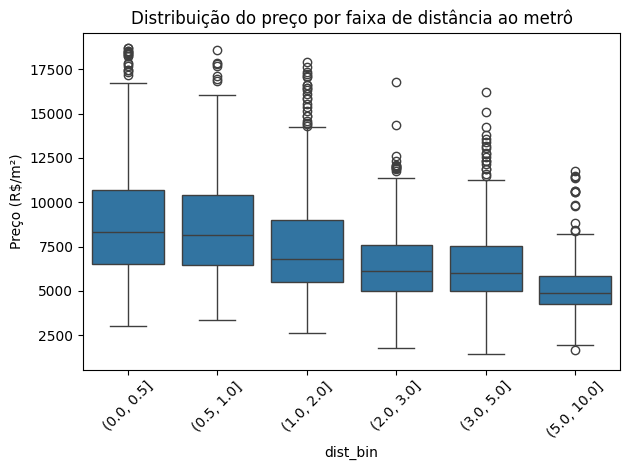

In [10]:
plt.figure()
sns.boxplot(x='dist_bin', y='unit', data=gdf_imoveis)
plt.xticks(rotation=45)
plt.ylabel('Preço (R$/m²)')
plt.title('Distribuição do preço por faixa de distância ao metrô')
plt.tight_layout()
plt.show()


### Correlação preço × distância e prêmio por linha

In [11]:
corr = gdf_imoveis['unit'].corr(gdf_imoveis['dist_km'])
print('Correlação Pearson (unit vs dist_km):', corr)

premio_linha = gdf_imoveis[gdf_imoveis['dist_km'] <= 1].groupby('linha_prox')['unit'].mean().sort_values(ascending=False)
premio_linha


Correlação Pearson (unit vs dist_km): -0.3402107515235063


linha_prox
AMARELA     10796.610200
LILAS        9923.616577
VERDE        9190.064675
AZUL         8873.718690
VERMELHA     8035.157854
PRATA        7070.006207
Name: unit, dtype: float64

## 4. Visualização espacial interativa

In [12]:
m = folium.Map(location=[-23.55, -46.63], zoom_start=11)

# pontos das estações
for _, r in gdf_estacoes.iterrows():
    folium.CircleMarker(
        location=[r.lat, r.lon],
        radius=4,
        color='black',
        fill=True,
        fill_opacity=1,
        popup=r['name']
    ).add_to(m)

# amostra de imóveis (para performance, 500)
sample = gdf_imoveis.sample(500, random_state=42)
folium.Choropleth(
    geo_data=sample.__geo_interface__,
    data=sample,
    columns=['id', 'unit'],
    key_on='feature.properties.id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Preço R$/m²'
).add_to(m)

m


TypeError: Object of type Interval is not JSON serializable

## 5. Modelagem (OLS)

In [13]:
import statsmodels.formula.api as smf
model = smf.ols('np.log(unit) ~ np.log(dist_km) + area_util + quartos + suites', data=gdf_imoveis).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(unit)   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     377.1
Date:                Tue, 22 Apr 2025   Prob (F-statistic):          3.08e-254
Time:                        14:27:04   Log-Likelihood:                -536.90
No. Observations:                2499   AIC:                             1084.
Df Residuals:                    2494   BIC:                             1113.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.8940      0.024    364.382      0.000       8.846       8.942
np.log(dist_km)    -0.1174      0.006    -19.428      0.000      -0.129      -0.106
area_util          -0.0010      0.000     -4.850      0.000      -0.001      -0.001
quartos            -0.0554      0.013     -4.305      0.000      -0.081      -0.030
suites              0.2666      0.011     24.669      0.000       0.245       0.288
==============================================================================
Omnibus:                       70.374   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.826
Skew:                          -0.180   Prob(JB):                     4.34e-31
Kurtosis:                       4.101   Cond. No.                         381.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### (Opcional) Modelo Spatial Lag – requer PySAL

In [ ]:
# from libpysal.weights.contiguity import KNN
# from spreg import ML_Lag
# # gera matriz de pesos k=8
# coords = list(zip(gdf_imoveis.geometry.x, gdf_imoveis.geometry.y))
# w = KNN.from_array(coords, k=8)
# w.transform = 'r'
# y = np.log(gdf_imoveis['unit'].values)
# X = gdf_imoveis[['area_util','quartos','suites','dist_km']].values
# sl = ML_Lag(y, X, w=w, name_y='log_unit', name_x=['area','quartos','suites','dist_km'])
# sl.summary


ImportError: cannot import name 'KNN' from 'libpysal.weights.contiguity' (c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\libpysal\weights\contiguity.py)

## 6. Krigagem dos resíduos (exemplo)

In [15]:
# from pykrige.ok import OrdinaryKriging
# residuals = model.resid
# # amostra reduzida para demo
# sample = gdf_imoveis.sample(1000, random_state=0)
# OK = OrdinaryKriging(sample.geometry.x, sample.geometry.y, residuals.loc[sample.index],
#                      variogram_model='spherical')
# gridx = np.linspace(gdf_imoveis.geometry.x.min(), gdf_imoveis.geometry.x.max(), 200)
# gridy = np.linspace(gdf_imoveis.geometry.y.min(), gdf_imoveis.geometry.y.max(), 200)
# z, ss = OK.execute('grid', gridx, gridy)


## 7. Simulação de nova estação

In [16]:
# parâmetros
elasticity = -0.14  # da Spatial Lag
# localização hipotética
new_station = {'lat': -23.624, 'lon': -46.700}

def new_dist(row):
    d_old = row['dist']
    d_new = haversine((row.lat,row.lon),(new_station['lat'],new_station['lon']))*1000
    return min(d_old, d_new)

gdf_imoveis['dist_sim'] = gdf_imoveis.apply(new_dist, axis=1)
gdf_imoveis['unit_sim'] = gdf_imoveis['unit'] * (gdf_imoveis['dist_sim']/gdf_imoveis['dist'])**elasticity
impacto = gdf_imoveis['unit_sim'].sum() - gdf_imoveis['unit'].sum()
print(f'Valorização total simulada: R$ {impacto:,.0f}')


Valorização total simulada: R$ 1,076


## 8. Conclusões
Este notebook demonstra como combinar pandas, GeoPandas, Folium e modelagem estatística/espacial para quantificar a influência do transporte metroferroviário nos preços de imóveis. Sinta‑se à vontade para expandir as análises com outros fatores socioeconômicos ou ampliar para séries temporais.